## Library imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
import os
import json
import pandas as pd
import numpy as np
import joblib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from boruta import BorutaPy
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import RFE

## Function defs

In [ ]:
def load_dataset(filepath):
    return pd.read_csv(filepath)

def save_dataset(dataset, filepath):
    dataset.to_csv(filepath, index=False)

def dataset_split(dataset, split_size):
    return train_test_split(dataset, test_size=split_size, shuffle=False)

def sklearn_model_load(directory):
    model = joblib.load(f'{directory}/model.joblib')

    with open(f'{directory}/config.json', 'r') as config_file:
        config = json.load(config_file)

    return model, config

def sklearn_model_save(directory, model, config):
    if not os.path.exists(directory):
        os.makedirs(directory)

    joblib.dump(model, f'{directory}/model.joblib')

    with open(f'{directory}/config.json', 'w') as config_file:
        json.dump(config, config_file)

def keras_model_load(directory):
    model = load_model(f'{directory}/model.keras')

    with open(f'{directory}/config.json', 'r') as config_file:
        config = json.load(config_file)

    return model, config

def keras_model_save(directory, model, config):
    if not os.path.exists(directory):
        os.makedirs(directory)

    model.save(f'{directory}/model.keras')

    with open(f'{directory}/config.json', 'w') as config_file:
        json.dump(config, config_file)

def feature_selection_boruta(X, y):

    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

    boruta = BorutaPy(estimator=xgb, n_estimators='auto', random_state=42)
    boruta.fit(X.values, y.values)

    feature_ranking = pd.DataFrame({
        'Feature': X.columns,
        'Importance': boruta.ranking_,
        'Accepted': boruta.support_
    }).sort_values(by='Importance', ascending=True)

    selected_features = X.columns[boruta.support_]
    print("Selected Features:", selected_features)

    return selected_features, feature_ranking


## Import and preprocess dataset

In [ ]:
dataset = load_dataset('/content/drive/My Drive/Machine Learning/Final Project/energydata_complete.csv')
dataset['date'] = pd.to_datetime(dataset['date'])

In [ ]:
# add new features
dataset['NSM'] = (dataset['date'] - pd.to_datetime(dataset['date'].dt.date)).dt.total_seconds()

dataset['week_status'] = dataset['date'].dt.dayofweek.apply(lambda x: 'weekend' if x > 4 else 'workday')

dataset['weekday'] = dataset['date'].dt.day_name()

In [ ]:
# scale numerical columns
numerical_columns = [
    'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3',
    'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8',
    'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
    'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'NSM'
]

scaler = MinMaxScaler()
dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])

# encode categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')

categorical_columns = ['week_status', 'weekday']
encoded_categorical = encoder.fit_transform(dataset[categorical_columns])

encoded_columns = encoder.get_feature_names_out(categorical_columns)

encoded_df = pd.DataFrame(encoded_categorical, columns=encoded_columns, index=dataset.index)

dataset = dataset.drop(columns=categorical_columns)
dataset = pd.concat([dataset, encoded_df], axis=1)

In [ ]:
# Save the scaler and encoder
joblib.dump(scaler, '/content/drive/My Drive/Machine Learning/Final Project/scaler.joblib')
joblib.dump(encoder, '/content/drive/My Drive/Machine Learning/Final Project/encoder.joblib')

['/content/drive/My Drive/Machine Learning/Final Project/encoder.joblib']

## Feature Selection

In [ ]:
X = dataset.drop(['Appliances', 'date'], axis=1)

y = dataset['Appliances']

X_selection, feature_rankings = feature_selection_boruta(X,y)

Selected Features: Index(['lights', 'T3', 'RH_3', 'T4', 'T5', 'RH_6', 'T7', 'T8', 'T9', 'T_out',
       'NSM', 'weekday_Monday', 'weekday_Saturday', 'weekday_Tuesday',
       'weekday_Wednesday'],
      dtype='object')


In [ ]:
print(feature_rankings)

                Feature  Importance  Accepted
0                lights           1      True
30     weekday_Saturday           1      True
29       weekday_Monday           1      True
27                  NSM           1      True
19                T_out           1      True
33      weekday_Tuesday           1      True
15                   T8           1      True
13                   T7           1      True
12                 RH_6           1      True
17                   T9           1      True
34    weekday_Wednesday           1      True
9                    T5           1      True
7                    T4           1      True
6                  RH_3           1      True
5                    T3           1      True
28  week_status_workday           2     False
21               RH_out           2     False
20          Press_mm_hg           2     False
22            Windspeed           2     False
16                 RH_8           2     False
11                   T6           

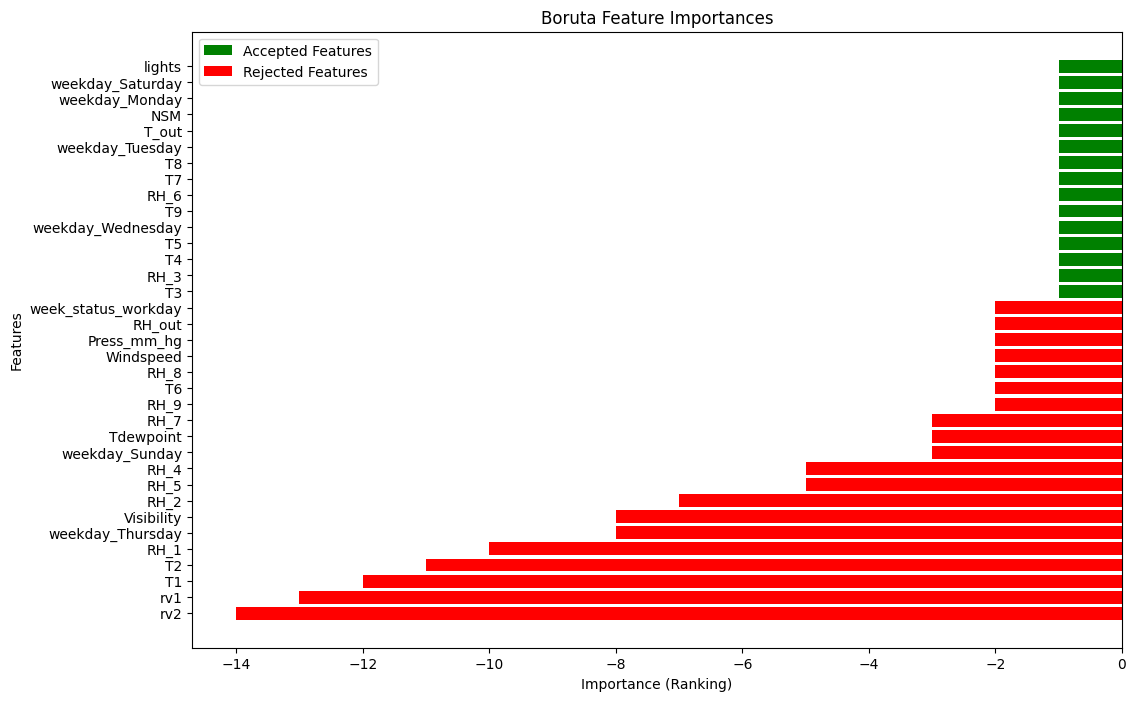

In [ ]:
# Visualization: Plot feature importances
plt.figure(figsize=(12, 8))
accepted_features = feature_rankings[feature_rankings['Accepted']]
rejected_features = feature_rankings[~feature_rankings['Accepted']]

plt.barh(accepted_features['Feature'], -accepted_features['Importance'], color='green', label='Accepted Features')
plt.barh(rejected_features['Feature'], -rejected_features['Importance'], color='red', label='Rejected Features')

plt.xlabel('Importance (Ranking)')
plt.ylabel('Features')
plt.title('Boruta Feature Importances')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [ ]:
dataset = dataset.drop(columns=['rv1', 'rv2'], axis=1)

save_dataset(dataset, '/content/drive/My Drive/Machine Learning/Final Project/energydata_preprocessed.csv')